In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.integrate import odeint

### Code for nonzero birthrate with pesticides model

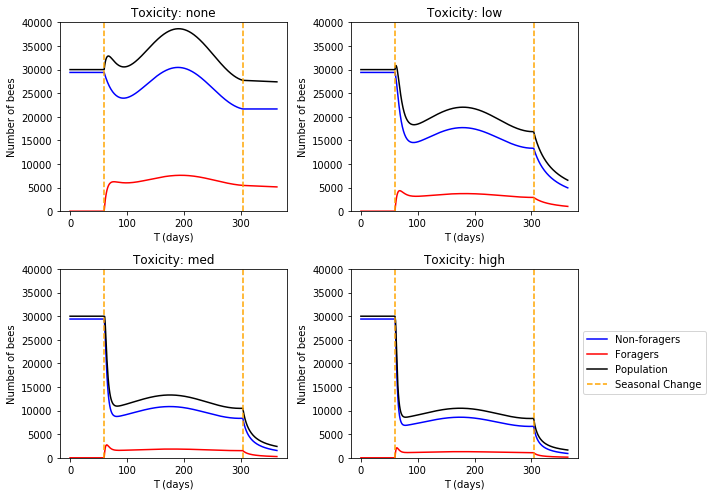

In [3]:
def ode_maker1(tox):
    toxicity_levels = {'high': .0001,
                       'med': .00005,
                       'low': .00001,
                       'none': 0}
    
    c = 0.05 # prop of workers becoming foragers
    d = .2 # normal death rate of foragers
    p = toxicity_levels[tox] # rate of bees dying from acute or sublethal exposure to pesticides
    
    def ode(y, t):
        t0 = t % 365
        if t0 > 60 and t0 < 304:
            b = lambda T: 250*np.sin((2*np.pi*T/245)+60)+1300
            d = .2
            c = 0.05
        else:
            b = lambda T: 0*T
            d = .001
            c = 0
            
        W = y[0] # non-forager workers
        F = y[1] # foragers
        N = y[2] # population
        return np.array([b(t0) + -c*W - p*W*F,
                         c*W - d*F - p*F*F,
                         b(t0) - p*W*F - d*F - p*F*F])
    return ode

# Set up initial values
total_hive_population = 30000
worker_bees = int(.98*30000)
non_foragers = worker_bees * 1
foragers = worker_bees * 0
dead = 0
y0 = np.array([non_foragers, foragers,total_hive_population]) 
t0 = 0
tf =  365 

for i, toxicity in enumerate(['none', 'low', 'med', 'high']):
    built_ode = ode_maker1(toxicity)

    # Calculate ODE
    t = np.arange(tf)
    sol = odeint(built_ode, y0, t)
    n = sol[:,2]
    # Plot results
    plt.subplot(2, 2, i+1)
    plt.plot(t, sol[:,0], label='Non-foragers', color='blue')
    plt.plot(t, sol[:,1], label='Foragers', color='red')
    plt.plot(t, sol[:,2], label='Population', color='black')
    plt.axvline(x=60, linestyle='--', color='orange',label='Seasonal Change')
    plt.axvline(x=304, linestyle='--', color='orange')
    plt.ylabel('Number of bees')
    plt.xlabel('T (days)')
    plt.ylim(0,40000)
    plt.title('Toxicity: {}'.format(toxicity))
plt.legend(bbox_to_anchor=(1,.5,.3,.2))
plt.gcf().set_size_inches(10, 7)
plt.tight_layout()
plt.show()

### Code for nonzero birthrate with mites model

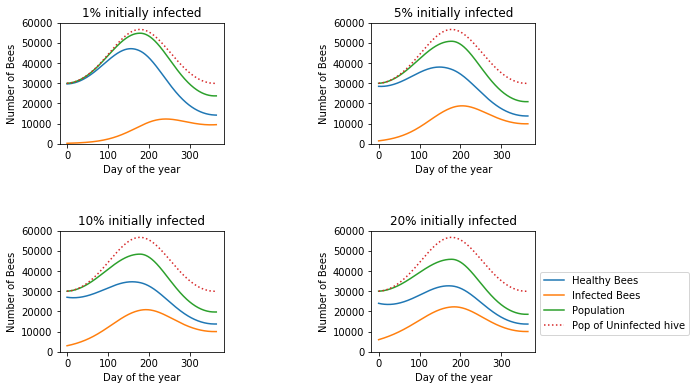

In [9]:
γ = 1.3 #infection rate
ω = .75 #recovery rate
t = np.linspace(0,12,365)
K = 60000 #carying capacity
death_rate  = .3
y = [.99,.01,30000]
def ODE(y,t,γ,ω):
    sus,inf,N = y
    if np.cos(t*(2*np.pi/12)-1.5)*N/6 > 0: 
        return [(-inf*γ*sus+ω*inf),(inf*γ*sus - ω*inf),(1-inf)*np.cos(t*(2*np.pi/12)-1.5)*N/6]
    else:
        return [(-inf*γ*sus+ω*inf),(inf*γ*sus - ω*inf),(1+inf)*np.cos(t*(2*np.pi/12)-1.5)*N/6]

sol = odeint(ODE,y,t,args = (γ,ω))
y = [1,0,30000]
γ = 0
healthy_sol = odeint(ODE,y,t,args = (γ,ω))
M = np.linspace(0,365,365)
n = sol[:,2]
inf_rate = [.01,.05,.1,.2]
rates = ["1% initially infected","5% initially infected","10% initially infected","20% initially infected"]

for i in range(4):
    γ = 1.3 #infection rate
    ω = .75 #recovery rate
    y = [1 - inf_rate[i],inf_rate[i],30000]
    t = np.linspace(0,12,365)
    sol = odeint(ODE,y,t,args = (γ,ω))
    y = [1,0,30000]
    γ = 0
    healthy_sol = odeint(ODE,y,t,args = (γ,ω))
    plt.subplot(2,2,(i+1))
    plt.plot(M,sol[:,0]*n,label = 'Healthy Bees')
    plt.plot(M,(sol[:,1]*n),label = 'Infected Bees')
    plt.plot(M,sol[:,2],label = 'Population')
    plt.plot(M,healthy_sol[:,2],label = "Pop of Uninfected hive",linestyle = ':')
    plt.title(rates[i])
    plt.xlabel("Day of the year")
    plt.ylabel("Number of Bees")
    plt.ylim(0,60000)
    
plt.legend(bbox_to_anchor=(1., .5, 0.3, 0.2))
plt.tight_layout()
plt.gcf().set_size_inches(14,6)
plt.show()


### Code for combined model

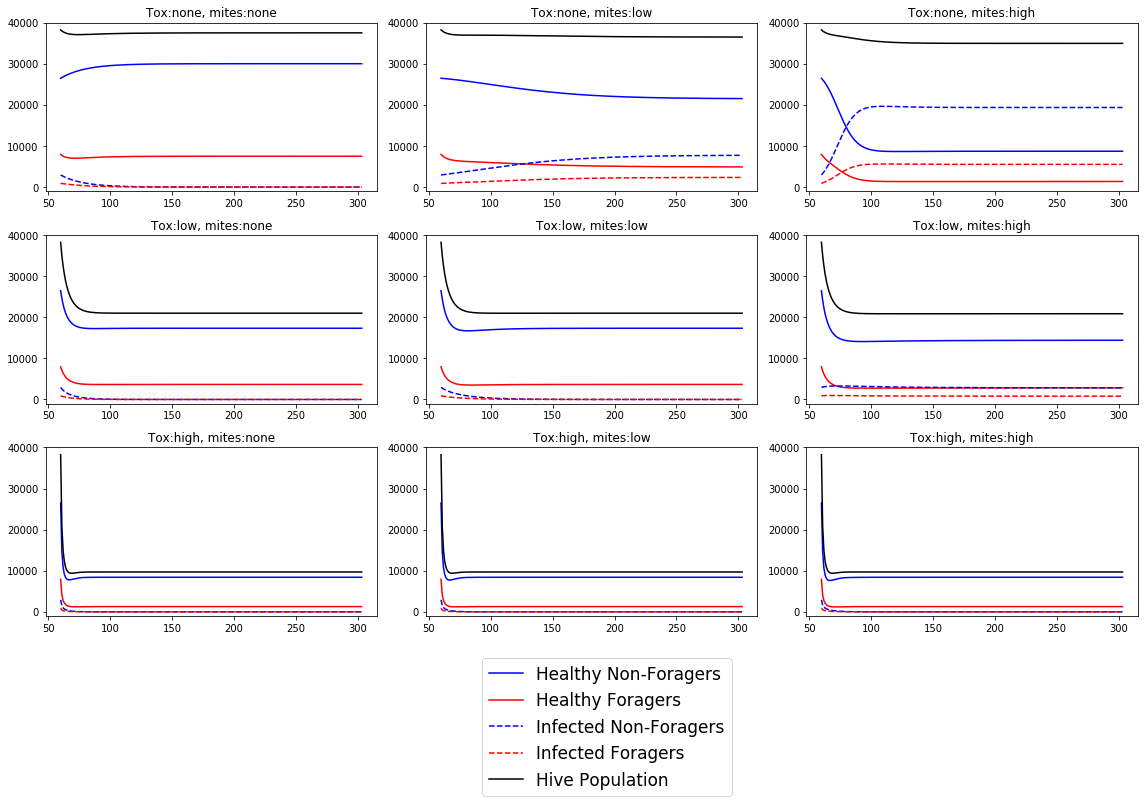

In [4]:
def ode_maker(tox, mites):
    toxicity_levels = {'high': 1e-4,
                       'low': 1e-5,
                       'none': 0}
    
    mite_levels = {'high': 5e-6,
                   'low': 2e-6,
                   'none': 0}
    
    b = 1500 # birth rate
    c = 0.05 # prop of workers becoming foragers (0.05 allows for most non-foragers to become foragers by 40)
    d = 0.2 # normal death rate of foragers (0.2 allows for most foragers to die after 10 days)
    
    q = toxicity_levels[tox] # rate of bees dying from acute or sublethal exposure to pesticides
    y = mite_levels[mites] #infection rate parasites
    w = 1e-3 #recovery rate parasites
    z = 5e-3 #death rate parasites

    def ode(t,y0):
        Hn = y0[0] #healthy nonforagers
        Hf = y0[1] #healthy foragers
        In = y0[2] #infected non-foragers
        If = y0[3] #infected non-foragers
        arr =  np.array([-c*Hn - y*(In+If)*Hn - q*(Hf+If)*Hn + w*In + b,
                          c*Hn - y*(In+If)*Hf - q*(Hf+If)*Hf + w*If - d*Hf,
                         -c*In + y*(In+If)*Hn - q*(Hf+If)*In - z*In - w*In,
                          c*In + y*(In+If)*Hf - q*(Hf+If)*If - z*If - w*If - d*If])
        return arr
    return ode

# initial conditions
hive_pop = 30000
workers = int(.98*hive_pop)
non_foragers = int(workers*.7)
foragers = int(workers*.3)

#suppose we start out with 10% of the hive infected with mites
initial_mite_outbreak = .1
Hn = workers*(1-initial_mite_outbreak)
Hf = foragers * (1 - initial_mite_outbreak)
In = workers * initial_mite_outbreak
If = foragers * initial_mite_outbreak

t0 = 60
tf = 304 # These start and end times model behavior for the summer
t = np.arange(t0, tf)
y0 = np.array([Hn, Hf, In, If])

i = 1
for tox in ['none', 'low', 'high']:
    for mites in ['none', 'low', 'high']:
        ODE = ode_maker(tox=tox, mites=mites)
        sol = solve_ivp(ODE, (t0, tf), y0, t_eval=t)
        
        plt.subplot(3, 3, i)
        plt.plot(t, sol.y[0],  c='blue', label = 'Healthy Non-Foragers')
        plt.plot(t, sol.y[1], c='red', label = 'Healthy Foragers')
        plt.plot(t, sol.y[2], c='blue', linestyle='--', label = 'Infected Non-Foragers')
        plt.plot(t, sol.y[3], c='red', linestyle='--', label = 'Infected Foragers')
        plt.plot(t, np.sum(sol.y,axis=0), c='black', label='Hive Population')
        plt.ylim(-1000, 40000)
        plt.title('Tox:{}, mites:{}'.format(tox, mites))
        i += 1

plt.gcf().set_size_inches(16, 9)
plt.tight_layout()
plt.legend(bbox_to_anchor=(-1.2, -1.2, 1, 1), prop={'size': 17})
plt.show()